In [74]:
import numpy as np
from typing import Literal, Tuple, Union
from matplotlib import colors
import matplotlib.pyplot as plt

In [75]:
def cal_speed_angle(
    s1: float,
    s2: float,
    unit: Literal['km/h', 'm/s'] = 'km/h'  # 'km/h' or 'm/s'
) -> Tuple[float, float, float, float]:
    """Calculate the angles of the speed limits and their average.

    Args:
        s1 (float): Speed of the first velocity vector.
        s2 (float): Speed of the second velocity vector.
        unit (Literal['km/h', 'm/s'], optional): Unit of the speed. Defaults to
            'km/h'.

    Returns:
        Tuple[float, float, float]: Angles of the speed limits and the average.
    """
    # convert to m/s
    if unit == 'km/h':
        s1 = s1 / 3.6
        s2 = s2 / 3.6
    # calculate angle
    theta1 = np.arctan(1 / s1)
    theta2 = np.arctan(1 / s2)
    theta = 0.5 * (theta1 + theta2)
    return theta1, theta2, theta


# test the function
s_rate=1
t_rate=100
s1=90
s2=91
std_s=20
std_t=5
unit='km/h'
theta1, theta2, theta = cal_speed_angle(s1, s2, unit)

In [76]:
def cal_cov_mat(
    sigma11: float = None,
    sigma22: float = None,
    eigvec: Union[np.ndarray, list] = None,
    eigval_prop: float = None
) -> np.ndarray:
    """Reconstruct the covariance matrix (of a 2D Gaussian distribution) given
        one variance, the first eigenvector (upto a scalar multiple), and the
        proportion of eigenvalues.

    Args:
        sigma11 (float, optional): Variance along the first axis (x-axis).
            Defaults to None.
        sigma22 (float, optional): Variance along the second axis (y-axis).
            Defaults to None.
        eigvec (Union[np.ndarray, list], optional): First eigenvector v1.
            Defaults to None.
        eigval_prop (float, optional): Proportion of the two eigenvalues
            (lambda1 / lambda2). Defaults to None.

    Returns:
        np.ndarray: The reconstructed covariance matrix.
    """
    if (sigma11 is None) + (sigma22 is None) != 1:
        raise ValueError('Either sigma11 or sigma22 must be provided.')
    if sigma11:
        denominator = eigval_prop * (eigvec[0] ** 2) + (eigvec[1] ** 2)
        sigma12 = eigvec[0] * eigvec[1] * (eigval_prop - 1)
        sigma12 = sigma11 * sigma12 / denominator
        sigma22 = eigval_prop * (eigvec[1] ** 2) + (eigvec[0] ** 2)
        sigma22 = sigma11 * sigma22 / denominator
    else:
        denominator = eigval_prop * (eigvec[1] ** 2) + (eigvec[0] ** 2)
        sigma12 = eigvec[0] * eigvec[1] * (eigval_prop - 1)
        sigma12 = sigma22 * sigma12 / denominator
        sigma11 = eigval_prop * (eigvec[0] ** 2) + (eigvec[1] ** 2)
        sigma11 = sigma22 * sigma11 / denominator
    cov_mat = np.array([[sigma11, sigma12], [sigma12, sigma22]])
    return cov_mat


# test the function
cov_mat = cal_cov_mat(
    sigma11=std_s ** 2,
    # sigma22=std_t ** 2,
    eigvec=[1, np.tan(theta)],
    eigval_prop=1 / np.tan(theta1 - theta)
)
cov_mat

array([[400.        ,  15.90858998],
       [ 15.90858998,   0.72075923]])

In [77]:
def create_gauss_kernel(
    cov_mat: np.ndarray,
    s_rate: float,
    t_rate: float,
    std_multi: float = 2
):
    """Create a 2D Gaussian kernel from the covariance matrix.

    Args:
        cov_mat (np.ndarray): Covariance matrix.
        s_rate (float): Spatial sampling rate.
        t_rate (float): Temporal sampling rate.
        std_multi (float, optional): Number of standard deviations to cover.
            Defaults to 2.

    Returns:
        np.ndarray: Gaussian kernel.
    """
    # Adjust the covariance matrix to the actual sampling rates
    cov_mat_adj = cov_mat.copy()
    cov_mat_adj[0, 0] *= s_rate ** 2
    cov_mat_adj[1, 1] *= t_rate ** 2
    cov_mat_adj[0, 1] *= s_rate * t_rate
    cov_mat_adj[1, 0] = cov_mat_adj[0, 1]

    # Get the standard deviations
    sigma_s = np.sqrt(cov_mat_adj[0, 0])
    sigma_t = np.sqrt(cov_mat_adj[1, 1])
    
    # Define the size of the kernel to cover 2 standard deviations each side
    kernel_size_s = int(np.ceil(sigma_s * std_multi))
    kernel_size_t = int(np.ceil(sigma_t * std_multi))

    # Create a grid of (x, y) coordinates
    range_s = np.arange(-kernel_size_s, kernel_size_s + 1)
    range_t = np.arange(-kernel_size_t, kernel_size_t + 1)
    x, y = np.meshgrid(range_s, range_t)

    # Calculate the Gaussian values
    det_cov_mat = np.linalg.det(cov_mat_adj)  # determinant of cov. matrix
    inv_cov_mat = np.linalg.inv(cov_mat_adj)  # inverse covariance matrix
    exponent = -0.5 * (
        inv_cov_mat[0, 0] * x**2 +
        2 * inv_cov_mat[0, 1] * x * y +
        inv_cov_mat[1, 1] * y**2
    )
    gauss_kernel = np.exp(exponent) / (2 * np.pi * np.sqrt(det_cov_mat))
    # Normalize the filter
    gauss_kernel /= np.sum(gauss_kernel)
    
    return gauss_kernel


# test the function
gauss_kernel = create_gauss_kernel(
    cov_mat,
    s_rate,
    t_rate
)
print(gauss_kernel.shape)

(341, 81)


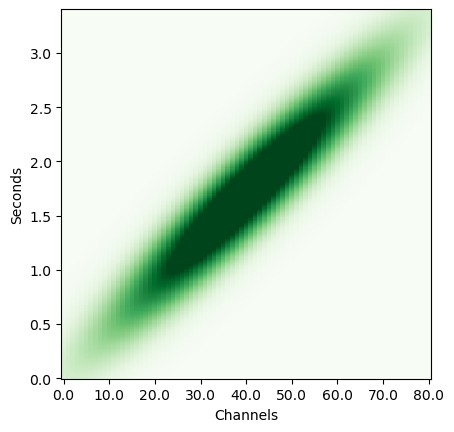

In [78]:
def heatmap_kernel(
    kernel: np.ndarray,
    s_rate: float,
    t_rate: float,
    aspect: float = None
) -> None:
    """Visualize kernel in heatmap.

    Args:
        kernel (np.ndarray): Kernel array.
        s_rate (float): Spatial sampling rate.
        t_rate (float): Temporal sampling rate.
        aspect (float, optional): Aspect ratio of the plot. Defaults to None.
    """
    percentile = np.quantile(np.abs(kernel), 0.95)
    vmin = 0
    vmax = percentile
    norm = colors.TwoSlopeNorm(
        vmin=vmin,
        vmax=vmax,
        vcenter=(vmin + vmax) / 2
    )
    cmap = 'Greens'
    if aspect is None:
        aspect = kernel.shape[1] / kernel.shape[0]
    plt.imshow(
        X=kernel,
        aspect=aspect,  # square
        cmap=cmap,
        norm=norm,
        interpolation='none',  # no interpolation
        origin='lower'
    )
    plt.xlabel('Channels')
    plt.ylabel('Seconds')

    # Get the current tick locations
    current_xticks = plt.gca().get_xticks()[1:-1]
    current_yticks = plt.gca().get_yticks()[1:-1]

    # Create new tick locations by dividing by sampling rate
    new_xticks = current_xticks / s_rate
    new_xticks = np.round(new_xticks, 2)
    new_yticks = current_yticks / t_rate
    new_yticks = np.round(new_yticks, 2)

    # Set the new tick locations
    plt.gca().set_xticks(current_xticks)
    plt.gca().set_xticklabels(new_xticks)

    plt.gca().set_yticks(current_yticks)
    plt.gca().set_yticklabels(new_yticks)


# test the function
heatmap_kernel(kernel=gauss_kernel, s_rate=s_rate, t_rate=t_rate)